In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# The data is stored as a NumPy array
X, y = mnist["data"], mnist["target"]



In [4]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

In [5]:
def load_batch(X,y,batch_size=64):
    n = X.shape[0]

    for i in range(0,n,batch_size):
        begin,end = i, min(i + batch_size,n)

        if y is not None:
            yield X[begin:end],y[begin:end]

        else:
            yield X[begin:end]
    

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [7]:
X_train,X_test = X_train/255.0,X_test/255.0
X_test.shape

(14000, 784)

In [8]:
def to_categorical(x, n_col=None):
    if not n_col:
        n_col = np.max(x) + 1
        one_hot = np.zeros ((x.shape[0], n_col))
        one_hot [np. arange (x.shape[0]), x] = 1
        return one_hot

In [9]:
y_train = to_categorical(y_train.astype("int"))

In [10]:
y_test = to_categorical(y_test.astype("int"))

In [11]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], shape=(56000, 10))

In [12]:
class CrossEntropy():
  def __init__(self): pass

  def loss(self, y, p):
    p = np.clip(p, 1e-15, 1- 1e-15)
    return -y*np.log(p) - (1 - y) * np.log(1- p)
  
  def gradient(self, y, p):
    p = np.clip(p, 1e-15, 1- 1e-15)
    return -(y/p) + (1 - y) / (1 - p)

In [13]:
class LeakyRELU():
    def __init__(self,alpha=0.2):
        self.alpha = alpha

    def __call__(self,x):
        return self.forward(x)

    def forward(self,x):
        return np.where(x>=0,x,self.alpha*x)
    
    def backward(self,x):
        return np.where(x>=0,1,self.alpha)

In [14]:
class CrossEntropy:
    def __init__(self):
        pass

    def loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.sum(y_true * np.log(y_pred), axis=-1)

    def gradient(self, y_true, y_pred):
        return y_pred - y_true

In [15]:
class Softmax:
    def __init__(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    def backward(self, x):
        s = self.forward(x)
        return s * (1 - s)

In [16]:
class Activation():
    def __init__(self,activation,name="activation"):
        self.activation = activation
        self.gradient = activation.backward
        self.input = None
        self.output = None

    def forward(self,x):
        self.input = x 
        self.output = self.activation(x)
        return self.output
    
    def backward(self,grad_flow):
        return self.gradient(self.input)*grad_flow
    
    def __call__(self, x):
        return self.forward(x)


In [37]:
class Dropout:
    def __init__(self,dropout_rate):
        self.dropout_rate = dropout_rate
        self.training = True
        self.mask = None

    def __call__(self, x):
        if(self.training):
            self.mask = (np.random.rand(*x.shape) > self.dropout_rate).astype(np.float32)
            return x * self.mask / ( 1.0 - self.dropout_rate)
        else:
            return x
        
    def backward(self,grad_output):
        if self.training:
            return grad_output * self.mask / (1.0 - self.dropout_rate)
        else:
            return grad_output

In [38]:
class Layer():

    def __init__(self, n_in, n_out, name="linear"):
        n = 1 / np.sqrt(n_in)
        # init weights
        self.weights = np.random.uniform(-n, n, size=(n_in, n_out))
        self.bias = np.zeros((1, n_out))
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x
        output = np.dot(x, self.weights) + self.bias
        self.output = output
        return output

    def backward(self, grad_flow, learning_rate=0.01):
        # grad_flow: (batch_size, n_out)
        input_error = np.dot(grad_flow, self.weights.T)  # (batch_size, n_in)
        delta_W = np.dot(self.input.T, grad_flow)        # (n_in, n_out)

        self.weights -= learning_rate * delta_W
        self.bias -= learning_rate * np.mean(grad_flow, axis=0, keepdims=True)

        return input_error

    def __call__(self, x):
        return self.forward(x)


In [45]:
class MLP():
    def __init__(self,input_dim,output_dim,dropout_rate):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers = [
            Layer(input_dim,256,"input"),
            Activation(LeakyRELU(),name="input"),
            Dropout(dropout_rate=dropout_rate),

            Layer(256,128,name="input"),
            Activation(LeakyRELU(),name="input"),
            Dropout(dropout_rate=dropout_rate),

            Layer(128,64,name="input"),
            Activation(LeakyRELU(),name="input"),
            Dropout(dropout_rate=dropout_rate),
            
            Layer(64,10,name="input"),
            Activation(Softmax(),name="output")
        ]

        self.lr = 0.01

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)

        return x
    
    def backward(self,grad_flow):
        for layer in reversed(self.layers):
            grad_flow = layer.backward(grad_flow)

    def train(self, mode=True):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = mode

    def __call__(self, x):
        return self.forward(x)

In [46]:
model = MLP(784,10,dropout_rate = 0.1)
criterian = CrossEntropy()

model.train(mode=True)

In [41]:
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

In [49]:
for epoch in range(10):
  loss = []
  acc = []
  for x_batch, y_batch in load_batch(X_train, y_train):
    out = model(x_batch) # Forward pass
    loss.append(np.mean(criterian.loss(y_batch, out))) # Loss - for display
    # We just passed the inputs incorrectly.
    acc.append(accuracy(y_batch, out))
    error = criterian.gradient(y_batch, out) # Calculate gradient of loss
    model.backward(error) # Backpropagation
  
  print(f"Epoch {epoch + 1}, Loss: {np.mean(loss)}, Acc: {np.mean(acc)}")

Epoch 1, Loss: 0.04764431857474081, Acc: 0.9872678571428571
Epoch 2, Loss: 0.04585108347296649, Acc: 0.988
Epoch 3, Loss: 0.04354989461555127, Acc: 0.9889642857142857
Epoch 4, Loss: 0.043605834290940754, Acc: 0.9882678571428571
Epoch 5, Loss: 0.04136724332056346, Acc: 0.9893035714285714
Epoch 6, Loss: 0.040310807511487044, Acc: 0.9894821428571429
Epoch 7, Loss: 0.042287231157435747, Acc: 0.9891964285714285
Epoch 8, Loss: 0.039254560627530674, Acc: 0.9895178571428571
Epoch 9, Loss: 0.0398987827088587, Acc: 0.9898928571428571
Epoch 10, Loss: 0.03681191937504354, Acc: 0.9906607142857143


X_test shape: (14000, 784)


Epoch 1, Loss: 0.7800219681735377, Acc: 0.7562857142857143
Epoch 2, Loss: 0.2210455708121314, Acc: 0.9383571428571429
Epoch 3, Loss: 0.15388059018723596, Acc: 0.9574464285714286
Epoch 4, Loss: 0.1229797052552209, Acc: 0.9670357142857143
Epoch 5, Loss: 0.10356814135585371, Acc: 0.9733571428571428
Epoch 6, Loss: 0.08878785984205777, Acc: 0.9775714285714285
Epoch 7, Loss: 0.07727036740633787, Acc: 0.9810892857142857
Epoch 8, Loss: 0.06851667633956798, Acc: 0.983625
Epoch 9, Loss: 0.061969628189894384, Acc: 0.985875
Epoch 10, Loss: 0.05699097083491795, Acc: 0.9869285714285714


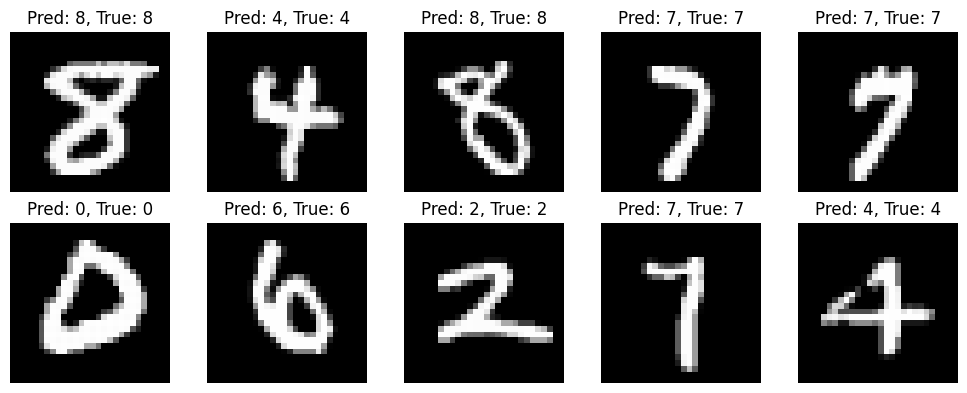

In [50]:
#plot predictions
def plot_predictions(X, y, model, num_images=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {np.argmax(model(X[i:i+1]))}, True: {np.argmax(y[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_predictions(X_test, y_test, model, num_images=10)

In [51]:
test_accuracy = accuracy(y_test,model(X_test))

In [52]:
test_accuracy

np.float64(0.9721428571428572)

In [58]:
y = np.arange(len(loss))


In [59]:
y

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [65]:
y = reversed(y)

TypeError: 'reversed' object is not reversible

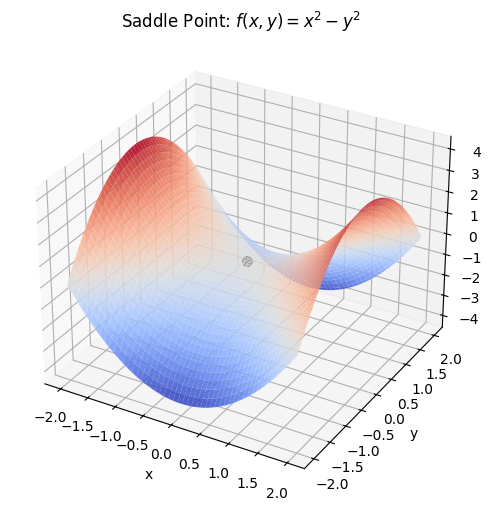

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the saddle function
def saddle(x, y):
    return x**2 - y**2

# Create a grid of points
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = saddle(X, Y)

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.9)

# Add labels and title
ax.set_title('Saddle Point: $f(x, y) = x^2 - y^2$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

# Show saddle point
ax.scatter(0, 0, 0, color='black', s=50)
plt.show()

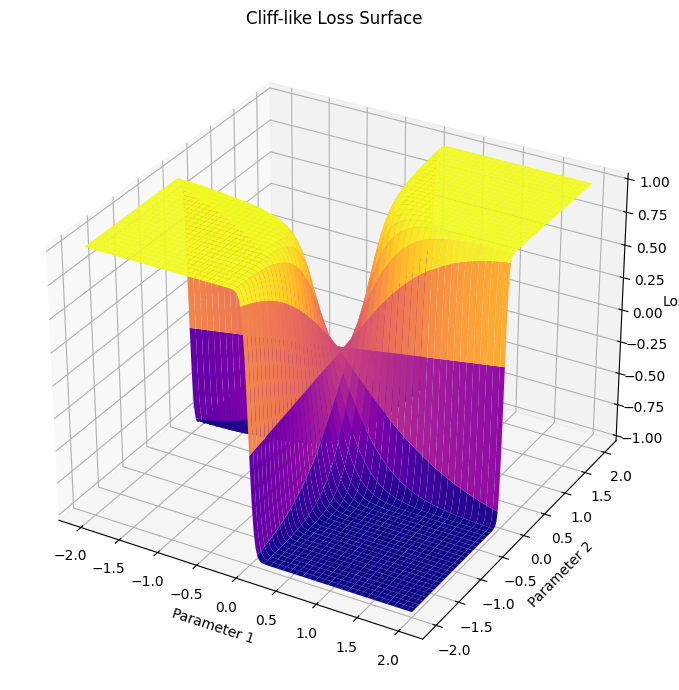

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def cliff_function(x, y):
    return np.tanh(10*x * y)

x = np.linspace(-2, 2, 200)
y = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)
Z = cliff_function(X, Y)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none')
ax.set_title('Cliff-like Loss Surface')
ax.set_xlabel('Parameter 1')
ax.set_ylabel('Parameter 2')
ax.set_zlabel('Loss')
plt.tight_layout()
plt.show()

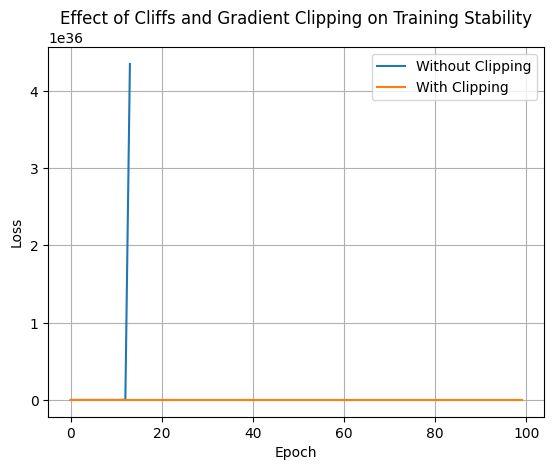

In [58]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(0)

# Simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use output from last time step
        return out

# Toy dataset: learn to sum values over a sequence
def generate_data(batch_size=64, seq_len=20):
    X = torch.rand(batch_size, seq_len, 1)
    y = X.sum(dim=1)
    return X, y

# Training loop
def train(model, use_clipping=False, clip_value=1.0):
    optimizer = torch.optim.SGD(model.parameters(), lr=1.0)  # High LR to exaggerate cliff effects
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(100):
        model.train()
        x, y = generate_data()
        output = model(x)
        loss = criterion(output, y)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()

        if use_clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

    return losses

# Train without clipping (observe cliff behavior)
model1 = SimpleRNN(1, 16)
losses1 = train(model1, use_clipping=False)

# Train with gradient clipping
model2 = SimpleRNN(1, 16)
losses2 = train(model2, use_clipping=True, clip_value=1.0)

# Plot
plt.plot(losses1, label='Without Clipping')
plt.plot(losses2, label='With Clipping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Effect of Cliffs and Gradient Clipping on Training Stability')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR


In [3]:
class SimpleNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fc = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64,10),
        ) 
    
    def forward(self,x):
        return self.fc(x)
    
    

In [4]:
# Training function
def train(model, loader, optimizer, criterion, device):
    model.train()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation function
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std for MNIST
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

device = torch.device('mps' if torch.mps.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

print(device)


mps


In [5]:
train_loader = DataLoader(train_dataset,shuffle=True,batch_size=64)
test_loader = DataLoader(test_dataset,batch_size = 64,shuffle=True)

model = SimpleNN().to(device)
optimizer = optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss()

In [6]:
losses = []
epochs = []
lr_vis = []

for epoch in range(10): 
    model.train()
    for images,labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        epochs.append(epoch)
        loss.backward()
        optimizer.step()

    acc = evaluate(model,test_loader,device)
    print(f"Acc: {acc}: Epoch : {epoch}")

Acc: 0.9664: Epoch : 0
Acc: 0.9711: Epoch : 1
Acc: 0.9759: Epoch : 2
Acc: 0.9769: Epoch : 3
Acc: 0.9762: Epoch : 4
Acc: 0.9763: Epoch : 5
Acc: 0.9803: Epoch : 6
Acc: 0.9805: Epoch : 7
Acc: 0.9769: Epoch : 8
Acc: 0.9808: Epoch : 9


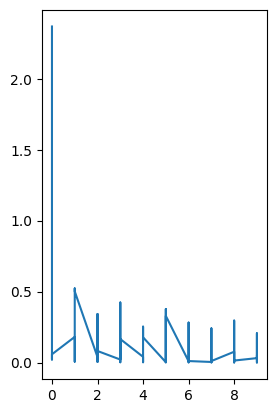

In [7]:
# plt.subplot(1,2,1)
# plt.plot(np.arange(0,50),lr_vis)
import matplotlib.pyplot as plt
#i want y values to range from 0 to 4
plt.subplot(1,2,1)
plt.plot(epochs,losses)

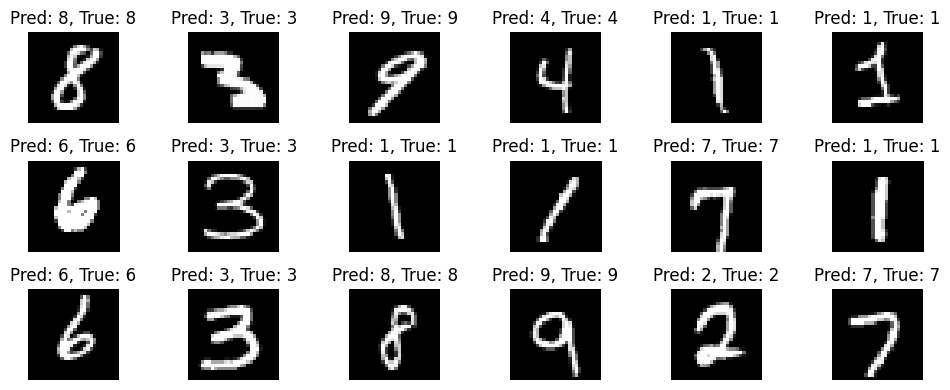

In [12]:
#plot image from one batch from train_loader

for images, labels in train_loader:
    plt.figure(figsize=(10, 4))
    for i in range(18):
        plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].squeeze().cpu(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        image = images[i].unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(image)
            pred_label = pred.argmax(dim=1).item()
        plt.title(f"Pred: {pred_label}, True: {labels[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break  # Show only one batch

In [138]:
torch.mean(torch.mean(train_dataset.data.float() / 255.0, dim=(0, 1))) , torch.mean(torch.std(train_dataset.data.float() / 255.0, dim=(0, 1)))

(tensor(0.1307), tensor(0.2362))

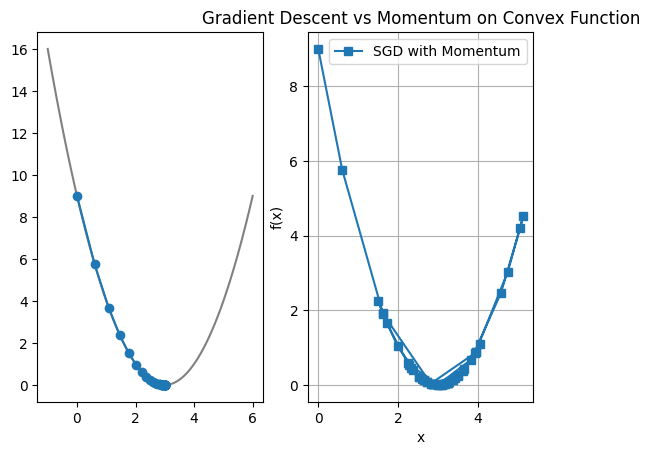

In [161]:
import numpy as np
import matplotlib.pyplot as plt

# Convex function: f(x) = (x - 3)^2
def f(x):
    return (x - 3) ** 2

# Gradient of f(x)
def grad_f(x):
    return 2 * (x - 3)

# Gradient descent without momentum
def gradient_descent(lr=0.1, steps=50, x0=0):
    x = x0
    x_vals = [x]
    for _ in range(steps):
        x -= lr * grad_f(x)
        x_vals.append(x)
    return x_vals

# Gradient descent with momentum
def gradient_descent_momentum(lr=0.1, gamma=0.9, steps=50, x0=0):
    x = x0
    v = 0
    x_vals = [x]
    for _ in range(steps):
        g = grad_f(x)
        v = gamma * v + lr * g
        x -= v
        x_vals.append(x)
    return x_vals

# Run both methods
gd_vals = gradient_descent()
momentum_vals = gradient_descent_momentum()

# Plotting
x_range = np.linspace(-1, 6, 100)
plt.subplot(121)
plt.plot(x_range, f(x_range), label="f(x) = (x-3)^2", color='gray')
plt.plot(gd_vals, [f(x) for x in gd_vals], 'o-', label="SGD")

plt.subplot(122)
plt.plot(momentum_vals, [f(x) for x in momentum_vals], 's-', label="SGD with Momentum")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("Gradient Descent vs Momentum on Convex Function")
plt.grid(True)
plt.show()

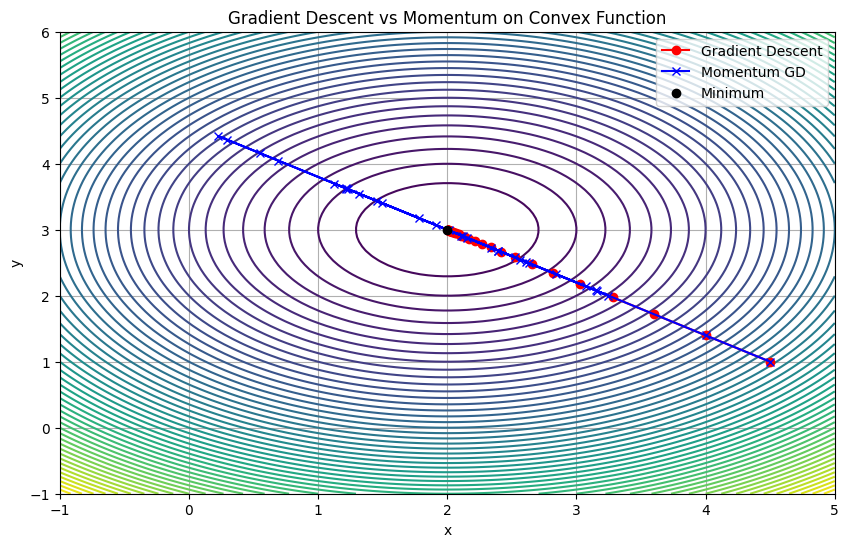

In [14]:
# Re-import necessary packages after code execution state reset
import numpy as np
import matplotlib.pyplot as plt

# Define the convex function and its gradient
def f(x, y):
    return (x - 2)**2 + (y - 3)**2

def grad_f(x, y):
    return np.array([2 * (x - 2), 2 * (y - 3)])

# Generate data for contour plot
x = np.linspace(-1, 5, 100)
y = np.linspace(-1, 6, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Gradient Descent without Momentum
def gradient_descent(grad, start, lr, steps):
    path = [start]
    point = start.copy()
    for _ in range(steps):
        point -= lr * grad(*point)
        path.append(point.copy())
    return np.array(path)

# Gradient Descent with Momentum
def momentum_gradient_descent(grad, start, lr, steps, momentum=0.9):
    path = [start]
    point = start.copy()
    velocity = np.zeros_like(point)
    for _ in range(steps):
        velocity = momentum * velocity - lr * grad(*point)
        point += velocity
        path.append(point.copy())
    return np.array(path)

# Run the optimizations
start_point = np.array([4.5, 1.0])
steps = 30
lr = 0.1

path_gd = gradient_descent(grad_f, start_point, lr, steps)
path_momentum = momentum_gradient_descent(grad_f, start_point, lr, steps, momentum=0.9)

# Plot contour and paths
plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.plot(path_gd[:, 0], path_gd[:, 1], marker='o', label='Gradient Descent', color='red')
plt.plot(path_momentum[:, 0], path_momentum[:, 1], marker='x', label='Momentum GD', color='blue')
plt.scatter(2, 3, color='black', label='Minimum', zorder=5)
plt.title('Gradient Descent vs Momentum on Convex Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#f(x) = 2*x^2
p = nn.Parameter(torch.tensor([1.0, 2.0]), requires_grad=True)

In [ ]:
# Example: compute gradient of f(p) = 2 * p^2 at p
import torch

p = torch.nn.Parameter(torch.tensor([1.0, 2.0]), requires_grad=True)

# Define a function of p
f = 2 * p**2

# Compute the sum to get a scalar output (required for backward)
loss = f.sum()
loss.backward()

# Now p.grad contains the gradient df/dp = 4*p
print("p.grad:", p.grad)

In [179]:
loss.item()

10.0

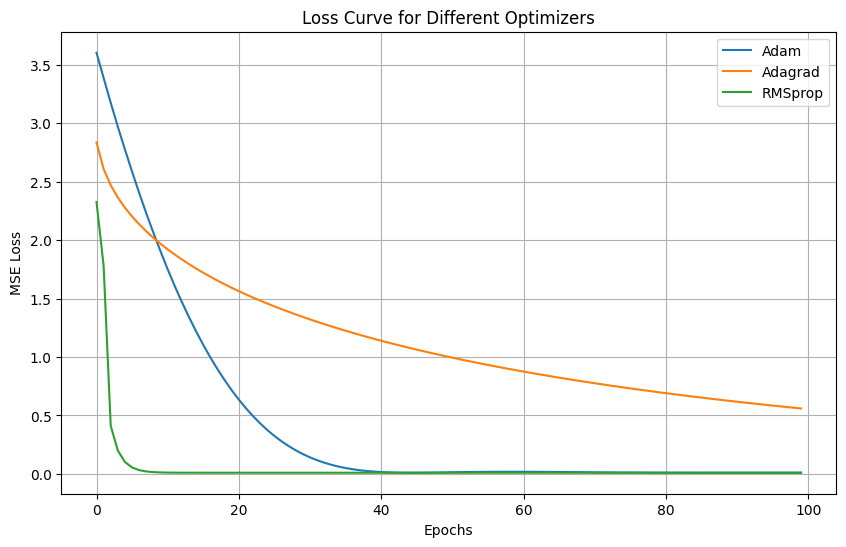

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate synthetic linear data: y = 3x + noise
torch.manual_seed(0)
X = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)
y = 3 * X + 0.1 * torch.randn(X.size())

# Define a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# Function to train and get loss history
def train_model(optimizer_type, X, y, epochs=100):
    model = LinearRegressionModel()
    criterion = nn.MSELoss()
    optimizer = optimizer_type(model.parameters(), lr=0.1)

    loss_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

    return loss_history

# Train using different optimizers
optimizers = {
    'Adam': optim.Adam,
    'Adagrad': optim.Adagrad,
    'RMSprop': optim.RMSprop
}

loss_histories = {}
for name, opt in optimizers.items():
    loss_histories[name] = train_model(opt, X, y)

# Plotting the loss curves
plt.figure(figsize=(10, 6))
for name, losses in loss_histories.items():
    plt.plot(losses, label=name)
plt.title('Loss Curve for Different Optimizers')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

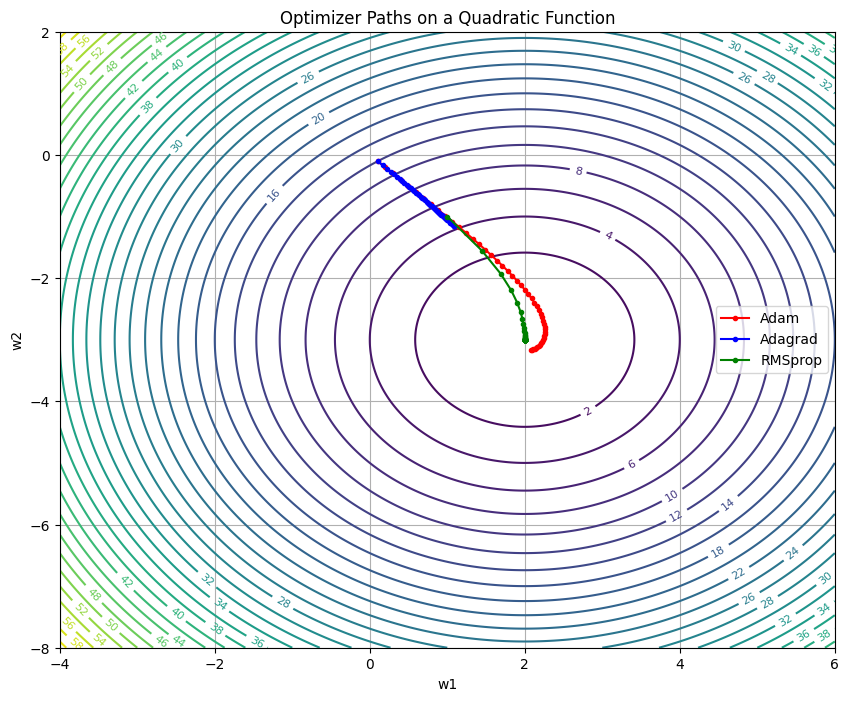

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Quadratic loss: f(w) = (w1 - 2)^2 + (w2 + 3)^2
def loss_fn(w):
    return (w[0] - 2)**2 + (w[1] + 3)**2

def train_optimizer(optimizer_type, lr=0.1, steps=50):
    w = torch.tensor([0.0, 0.0], requires_grad=True)
    #check if the optimizer is rmsprop to set some momentum
    if optimizer_type == optim.RMSprop:
        optimizer = optimizer_type([w], lr=lr, momentum=0.9)
    optimizer = optimizer_type([w], lr=lr)
    path = []

    for _ in range(steps):
        optimizer.zero_grad()
        loss = loss_fn(w)
        loss.backward()
        optimizer.step()
        path.append(w.detach().clone().numpy())
    
    return np.array(path)

paths = {
    'Adam': train_optimizer(optim.Adam),
    'Adagrad': train_optimizer(optim.Adagrad),
    'RMSprop': train_optimizer(optim.RMSprop),
}


# Contour plot of the loss surface
w1 = np.linspace(-4, 6, 300)
w2 = np.linspace(-8, 2, 300)
W1, W2 = np.meshgrid(w1, w2)
Z = (W1 - 2)**2 + (W2 + 3)**2

plt.figure(figsize=(10, 8))
cp = plt.contour(W1, W2, Z, levels=30, cmap='viridis')
plt.clabel(cp, inline=True, fontsize=8)

colors = {'Adam': 'red', 'Adagrad': 'blue', 'RMSprop': 'green'}
for name, path in paths.items():
    plt.plot(path[:, 0], path[:, 1], marker='o', label=name, color=colors[name], markersize=3)

plt.title("Optimizer Paths on a Quadratic Function")
plt.xlabel("w1")
plt.ylabel("w2")
plt.legend()
plt.grid(True)
plt.show()

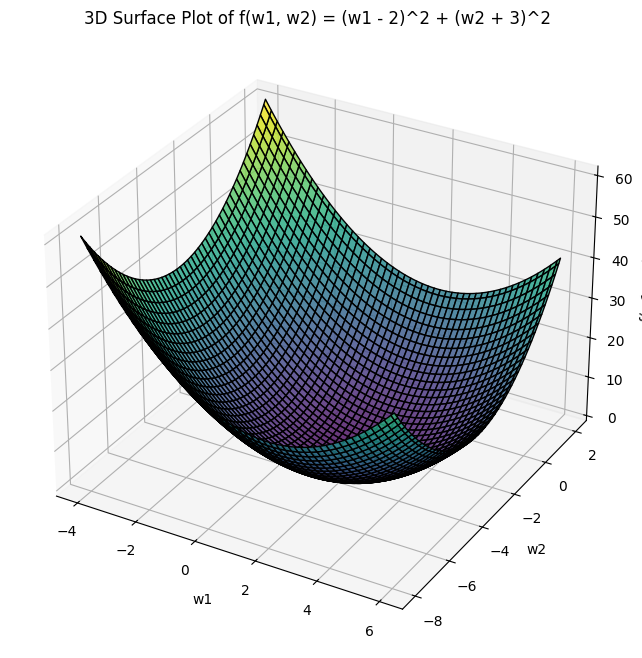

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(w1, w2):
    return (w1 - 2)**2 + (w2 + 3)**2

# Generate grid data
w1 = np.linspace(-4, 6, 100)
w2 = np.linspace(-8, 2, 100)
W1, W2 = np.meshgrid(w1, w2)
Z = f(W1, W2)

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, Z, cmap='viridis', edgecolor='k', alpha=0.8)

ax.set_title('3D Surface Plot of f(w1, w2) = (w1 - 2)^2 + (w2 + 3)^2')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('f(w1, w2)')

plt.show()

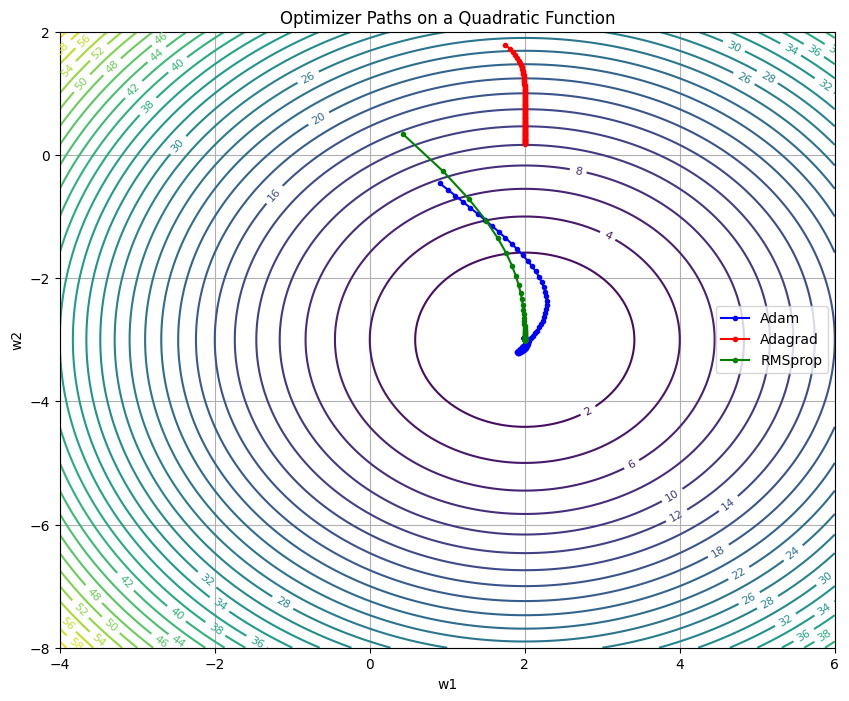

In [6]:
import numpy as np
import torch 
import matplotlib.pyplot as plt 
import torch.optim as optim

def loss_fn(w):
    return (w[0] - 2)**2 + (w[1] + 3)**2

def train_my_optimizer(optimizer_type,lr=0.1):
    w = torch.randn(2,requires_grad=True)
    optimizer = optimizer_type([w],lr=lr)

    losses = []

    for epoch in range(100):
        optimizer.zero_grad()
        loss = loss_fn(w)
        loss.backward()
        optimizer.step()
        losses.append(w.detach().clone().numpy())

    return np.array(losses)

paths = {
    'Adam': train_my_optimizer(optim.Adam),
    'Adagrad': train_my_optimizer(optim.Adagrad),
    'RMSprop': train_my_optimizer(optim.RMSprop),
}

x =np.linspace(-4, 6, 300)
y = np.linspace(-8, 2, 300)
X,Y = np.meshgrid(x,y)
Z = Z = (X - 2)**2 + (Y + 3)**2

plt.figure(figsize=(10, 8))
cp = plt.contour(X, Y, Z, levels=30, cmap='viridis')
plt.clabel(cp, inline=True, fontsize=8)

colors = {
    "Adam":"blue",
    "RMSprop" : "green",
    "Adagrad" : "red"
}

for name, path in paths.items():
    plt.plot(path[:, 0], path[:, 1], marker='o', label=name, color=colors[name], markersize=3)

plt.title("Optimizer Paths on a Quadratic Function")
plt.xlabel("w1")
plt.ylabel("w2")
plt.legend()
plt.grid(True)
plt.show()

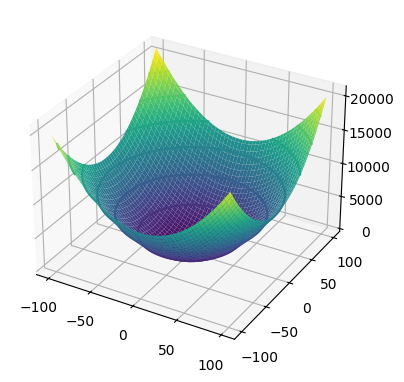

In [19]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(121,projection='3d')

ax.plot_surface(W1,W2,Z,cmap='viridis')

ax.contour3D(W1,W2,Z)